As per the topic analysis done it can be seen that the most of the topics in Elon Musk's tweets may not be in related to his takeover of twitter, so this is a specific sentmental analysis is on the replies of the tweet 'The bird is freed' which is directly related to the topic.

In [28]:
!pip3 install TwitterAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for TwitterAPI: filename=TwitterAPI-2.8.1-py3-none-any.whl size=14886 sha256=f1dbb03c418fed15f6fd7afcd299976368eb43f6c830dd618a4ecfdaebed48fc
  Stored in directory: /root/.cache/pip/wheels/10/74/6d/4e6fa6e03b090c568f92e387665cb28112494ed1c3bd3e09eb
Successfully built TwitterAPI


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [3]:
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = " ".join(word for word in temp)
    return temp

In [30]:
from TwitterAPI import TwitterAPI, TwitterOAuth, TwitterRequestError, TwitterConnectionError, TwitterPager
import tweepy
import csv
consumer_key = 'GzzTvTE4TO27FfkVX1YICJhz0'
consumer_secret = '5nxjEGLEn0tSNPN2pCKdOsJVkxfm2LV9Go2JLATo3354rEh0p7'
access_token_key = '1467812169110667264-5UWAm0TbEgS9lRpiZvJwLqaO1dvsKi' #same thing as access_token
access_token_secret = 'UWcqWXHOpIe7sX6IPFvrTBX2oJY0uIsMe4BcHL652gOup'
api = TwitterAPI(consumer_key, consumer_secret, access_token_key, access_token_secret, api_version='2')

author_id = []
text_reply = []
created_at = []

# The conversation_id field is always the Tweet ID of the original Tweet in the conversation reply thread. 
# All Tweets within the same reply thread, including reply threads that are created from earlier reply threads, will show the same conversation_id.
# the following conversation id is the tweet id of the tweet 'The bird is freed' to analyze users sentiment to this thread 
conv_id = '1585841080431321088'
def replies(conversation_id):
    pager = TwitterPager(api, 'tweets/search/recent',
                                 {
                                     'query': f'conversation_id:{conversation_id}',
                                     'tweet.fields': 'author_id,conversation_id,created_at,in_reply_to_user_id'
                                 })
    iterator = pager.get_iterator(wait=5)
    count = 0
    for item in iterator:
        author_id.append(item['author_id'])
        text_reply.append(item['text'])
        created_at.append(item['created_at'])
        count = count + 1
    return count                   # Returns a list (replies) and an integer (count)
count = replies(conv_id)

cleaned_reply = [clean_tweet(tw) for tw in text_reply]

df = pd.DataFrame({'Author id':author_id,'Text reply':text_reply,'Text reply cleaned':cleaned_reply,'Created_at': created_at})
format = "%Y-%m-%d %H:%M:%S"
df['Created_at'] = pd.to_datetime(df['Created_at'], format = format).dt.tz_localize(None)

df.to_csv('/content/drive/MyDrive/Elon_Musk_project/replies_to_birdFreed.csv', encoding='utf-8', index=False)
df.head(2)


<ipython-input-4-43d0976bd7bf>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


,Author id,Text reply,Text reply cleaned,Created_at
0,755088828768088065,@phil_viz @KariLake @elonmusk @Twitter Seems m...,seems mine aged much better than yours yes im ...,2023-01-10 14:35:06
1,755088828768088065,@AmandaG9671111 @KariLake @elonmusk @Twitter B...,been way more than a week but thought we shoul...,2023-01-10 14:20:21


In [4]:
#Read the file and also assign it to dataframe
filename = '/content/drive/MyDrive/Elon_Musk_project/replies_to_birdFreed.csv'
df_reply = pd.read_csv(filename) 

df_reply.head(2)

,Author id,Text reply,Text reply cleaned,Created_at
0,755088828768088065,@phil_viz @KariLake @elonmusk @Twitter Seems m...,seems mine aged much better than yours yes im ...,2023-01-10 14:35:06
1,755088828768088065,@AmandaG9671111 @KariLake @elonmusk @Twitter B...,been way more than a week but thought we shoul...,2023-01-10 14:20:21


# **TEXTBLOB**

In [5]:
from textblob import TextBlob
def get_tweet_sentiment(tweet):
    analysis = TextBlob(tweet)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

sentiment = [get_tweet_sentiment(tw) for tw in df_reply['Text reply']]
df_reply['sentiments'] = sentiment

# **VADER**

In [6]:
!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 14.0 MB/s eta 0:00:00


In [7]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']
    
compound_scores = [sentiment_scores(tw) for tw in df_reply['Text reply']]
df_reply['compound_scores'] = compound_scores

sentiment = []
for scores in compound_scores:
    if scores >= 0.05 :
       sentiment.append('positive')
    elif scores <= - 0.05 :
       sentiment.append('negative')
    else :
       sentiment.append('neutral')
     
df_reply['sentiments'] = sentiment
df_reply.head(2)

,Author id,Text reply,Text reply cleaned,Created_at,sentiments,compound_scores
0,755088828768088065,@phil_viz @KariLake @elonmusk @Twitter Seems m...,seems mine aged much better than yours yes im ...,2023-01-10 14:35:06,positive,0.7430
1,755088828768088065,@AmandaG9671111 @KariLake @elonmusk @Twitter B...,been way more than a week but thought we shoul...,2023-01-10 14:20:21,positive,0.7574


Total Positive Replies % : 36.51
Total Negative Replies % : 25.40
Total Neutral Replies % : 38.10


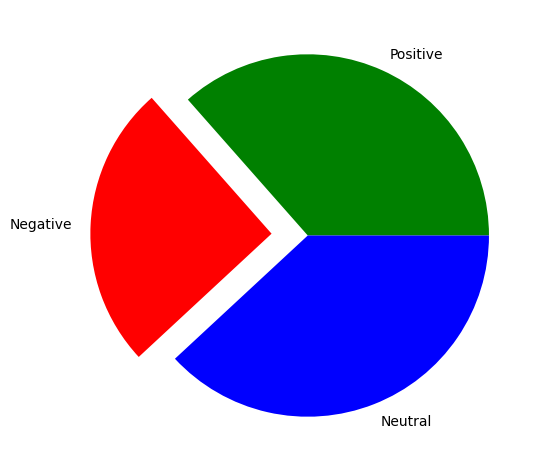

In [8]:
total_pos = 0
total_neg = 0
total_neu = 0
total_tweets = len(sentiment)
for i in range (len(sentiment)):
      if (sentiment[i] == "positive") : total_pos += 1
      elif (sentiment[i] == "negative") : total_neg += 1
      else : total_neu += 1
      
print("Total Positive Replies % : {:.2f}".format((total_pos/total_tweets)*100))
print("Total Negative Replies % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Replies % : {:.2f}".format((total_neu/total_tweets)*100))

mylabels = ["Positive", "Negative", "Neutral"]
mycolors = ["Green", "Red", "Blue"] 
plt.figure(figsize=(18, 6),dpi=100)  # Push new figure on stack
myexplode = [0, 0.2, 0]
plt.pie([total_pos, total_neg, total_neu], colors=mycolors, labels=mylabels, explode=myexplode)
plt.show()

[]

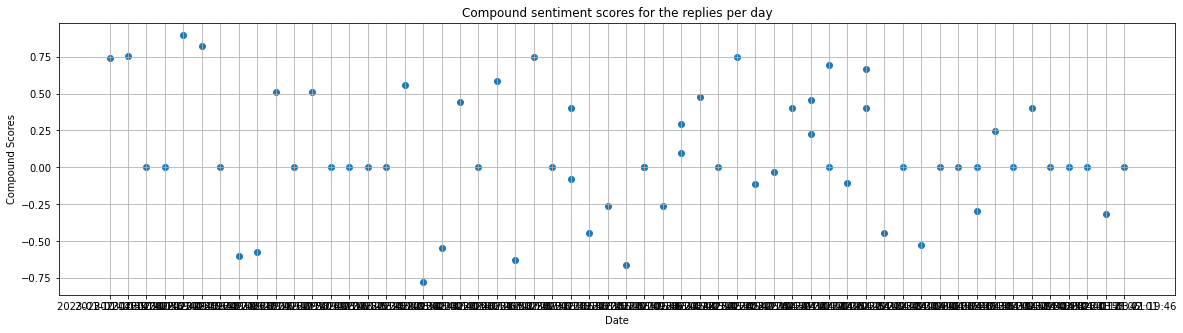

In [9]:
import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, splot = plt.subplots(figsize=(20, 5))
splot.scatter(df_reply["Created_at"], df_reply["compound_scores"])
splot.set(xlabel='Date',
       ylabel='Compound Scores',
       title='Compound sentiment scores for the replies per day')
plt.grid(True)
plt.plot()

# **NRCLex**

In [10]:
!pip3 install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 KB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=e362644b5364fb969f7c2dc703b5dc64982f7acf8862c20d97734822ad0fd2be
  Stored in directory: /root/.cache/pip/wheels/83/95/c0/42b43fb15eb48e4f5a67cba8915540cb2783591c59c037a9e5
Successfully built NRCLex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
def emotion_sentiment(text):
  emotion = NRCLex(text)
  return emotion.affect_frequencies

emotion_dic = [emotion_sentiment(text) for text in df_reply['Text reply']]
emotion_dic[0]

{'fear': 0.0,
 'anger': 0.0,
 'anticip': 0.0,
 'trust': 0.0,
 'surprise': 0.0,
 'positive': 0.0,
 'negative': 1.0,
 'sadness': 0.0,
 'disgust': 0.0,
 'joy': 0.0}

In [24]:
fear = []
anger = []
anticip = []
trust = []
surprise = []
positive = []
negative = []
sadness = []
disgust = []
joy = []

for item in emotion_dic:
  fear.append(item['fear'])
  anger.append(item['anger'])
  anticip.append(item['anticip'])
  trust.append(item['trust'])
  surprise.append(item['surprise'])
  positive.append(item['positive'])
  negative.append(item['negative']) 
  sadness.append(item['sadness']) 
  disgust.append(item['disgust'])
  joy.append(item['joy'])

df_reply = df_reply.assign(Fear=fear, Anger=anger, Anticip=anticip, Trust=trust, Surprise=surprise, 
                           Positive=positive, Negative=negative, Sadness=sadness, Disgust=disgust, Joy=joy)

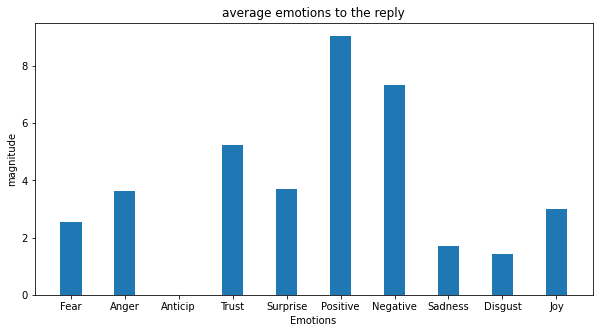

In [23]:
data = {'Fear':np.sum(df_reply['Fear']), 'Anger':np.sum(df_reply['Anger']), 'Anticip':np.sum(df_reply['Anticip']), 
        'Trust':np.sum(df_reply['Trust']), 'Surprise':np.sum(df_reply['Surprise']), 'Positive':np.sum(df_reply['Positive']), 
        'Negative':np.sum(df_reply['Negative']), 'Sadness':np.sum(df_reply['Sadness']), 'Disgust':np.sum(df_reply['Disgust']), 
        'Joy':np.sum(df_reply['Joy'])}
   
emotions = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(emotions, values, width = 0.4)
 
plt.xlabel("Emotions")
plt.ylabel("magnitude")
plt.title("average emotions to the reply")
plt.show()